In [1]:
import pandas as pd
import numpy as np
from impedance.models.circuits import CustomCircuit
from impedance import preprocessing
from impedance.visualization import plot_nyquist
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error

def remove_zeros(file_path, create_new_file):
    df = pd.read_csv(file_path, sep='\s+', header=None, skiprows=1)

    df = df.apply(pd.to_numeric, errors='coerce')

    #Set column names
    df.columns = ["|Z|/Ohm", "freq/Hz", "Re(Z)/Ohm", "-Im(Z)/Ohm", "cycle number"]

    #Remove zeros
    df_filtered = df[(df[['|Z|/Ohm', 'freq/Hz', 'Re(Z)/Ohm', '-Im(Z)/Ohm', 'cycle number']] != 0).all(axis=1)]

    if create_new_file == True:
        base_name = os.path.basename(file_path)
        name, ext = os.path.splitext(base_name)
        output_file_name = f"{name}_clean{ext}"
        output_file_path = os.path.join(os.path.dirname(file_path), output_file_name)
        df_filtered.to_csv(output_file_path, sep='\t', index=False, header=False)

    column_headers = df.iloc[0]

    return df_filtered

def plot_spectrum(df, battery_name, show_frequency_gradient):
    cycle_column, re_column, im_column, freq_column = 'cycle number', 'Re(Z)/Ohm', '-Im(Z)/Ohm', 'freq/Hz'
    fig = go.Figure()
    
    cycles = df[cycle_column].unique()
    traces = []
    buttons = []

    for i, cycle in enumerate(cycles):
        df_cycle = df[df[cycle_column] == cycle]
        if show_frequency_gradient:
            marker = dict(
                size=5.5, 
                color=df_cycle[freq_column], 
                colorscale='Viridis', 
                colorbar=dict(
                    title='Frequency (Hz)',
                    thickness=15,
                    len=0.5
                )
            )
        else:
            marker = dict(
                size=5.5,
            )
        
        trace = go.Scatter(
            x=df_cycle[re_column], 
            y=df_cycle[im_column], 
            mode='markers', 
            name=f'Cycle {int(cycle)}', 
            marker=marker
        )
        traces.append(trace)

    initial_visibility = [False] * len(cycles)
    for i, cycle in enumerate(cycles):
        button = dict(
            method='update',
            label=f'Cycle {int(cycle)}',
            visible=True,
            args=[{'visible': [(not visibility) if j == i else visibility for j, visibility in enumerate(initial_visibility)]},
                  {'title': f'Impedance Plot'}]
        )
        buttons.append(button)

    all_button = dict(method='update', label='All', visible=True, args=[{'visible': [True] * len(traces)}])
    buttons.append(all_button)

    fig.update_layout(
        autosize=False, 
        width=700, 
        height=600,
        updatemenus=[
            dict(
                type='buttons',
                direction='right',
                x=1.1,
                y=1.1,
                buttons=buttons
            )
        ],
        title=f'Impedance Plot of Battery {battery_name}',
        xaxis_title='Re(Z)/Ohm',
        yaxis_title='-Im(Z)/Ohm',
        showlegend=True,
        legend=dict(orientation='v', x=1.02, y=1)
    )

    for trace in traces:
        fig.add_trace(trace)

    fig.show()


In [2]:
file_paths = [
    ('Data/EIS_Data/NX001_2108_EIS.txt'),
    ('Data/EIS_Data/NX001_2401_EIS.txt'),
    ('Data/EIS_Data/NX002_2108_EIS.txt'),
    ('Data/EIS_Data/NX006_2108_EIS.txt'),
    ('Data/EIS_Data/NX006_2401_EIS.txt'),
    ('Data/EIS_Data/RS001_2108_EIS.txt'),
    ('Data/EIS_Data/RS006_2108_EIS.txt'),
    ('Data/EIS_Data/RS006_2401_EIS.txt'),
    ('Data/EIS_Data/SG003_2401_EIS.txt'),
    ('Data/EIS_Data/SG004_2401_EIS.txt'),
    ('Data/EIS_Data/SG007_2108_EIS.txt'),
    ('Data/EIS_Data/SG007_2401_EIS.txt'),
    ('Data/EIS_Data/SG008_2108_EIS.txt'),
    ('Data/EIS_Data/SG009_2108_EIS.txt'),
    ('Data/EIS_Data/SG009_2401_EIS.txt')
]

clean_data = []

for file_path in file_paths:
    df = remove_zeros(file_path, False)
    df.columns = ["|Z|/Ohm", "freq/Hz", "Re(Z)/Ohm", "-Im(Z)/Ohm", "cycle number"]
    battery_name = os.path.basename(file_path).split('_EIS.txt')[0]
    clean_data.append((df, battery_name)) 

df_NX001_2108, battery_name_NX001_2108 = clean_data[0]
df_NX001_2401, battery_name_NX001_2401 = clean_data[1]
df_NX002_2108, battery_name_NX002_2108 = clean_data[2]
df_NX006_2108, battery_name_NX006_2108 = clean_data[3]
df_NX006_2401, battery_name_NX006_2401 = clean_data[4]
df_RS001_2108, battery_name_RS001_2108 = clean_data[5]
df_RS006_2108, battery_name_RS006_2108 = clean_data[6]
df_RS006_2401, battery_name_RS006_2401 = clean_data[7]
df_SG003_2401, battery_name_SG003_2401 = clean_data[8]
df_SG004_2401, battery_name_SG004_2401 = clean_data[9]
df_SG007_2108, battery_name_SG007_2108 = clean_data[10]
df_SG007_2401, battery_name_SG007_2401 = clean_data[11]
df_SG008_2108, battery_name_SG008_2108 = clean_data[12]
df_SG009_2108, battery_name_SG009_2108 = clean_data[13]
df_SG009_2401, battery_name_SG009_2401 = clean_data[14]

In [3]:
df = df_NX001_2108
cycle_103_df = df[df["cycle number"] == 103].reset_index(drop=True)
freq_diff = cycle_103_df["freq/Hz"].diff().fillna(0)
freq_diff = cycle_103_df["freq/Hz"].diff().fillna(0)
first_increase_idx = freq_diff[freq_diff > 0].index[0]
df_NX001_2108_103 = cycle_103_df.iloc[:first_increase_idx]
df_NX001_2108_103 = df_NX001_2108_103[["|Z|/Ohm", "freq/Hz", "Re(Z)/Ohm", "-Im(Z)/Ohm", "cycle number"]]

In [4]:

def fit_ecm_model(df, circuit='R0-p(R1,C1)-p(R2-Wo1,C2)', number_of_components=7):

    initial_guess = [1] * number_of_components
    # Load data from df
    freq = df['freq/Hz'].values
    Z = df['Re(Z)/Ohm'].values - 1j * df['-Im(Z)/Ohm'].values
    
    circuit_model = CustomCircuit(circuit, initial_guess=initial_guess)
    circuit_model.fit(freq, Z)
    Z_fit = circuit_model.predict(freq)

    fitted_params = circuit_model.parameters_

    mse = mean_squared_error(np.real(Z), np.real(Z_fit)) + mean_squared_error(np.imag(Z), np.imag(Z_fit))

    return Z_fit, fitted_params, mse


In [5]:
#One very slow circuit
all_model_data = []
slow_circuit = ('R0-p(CPE1,R1)-p(CPE2,R2)-Wo1', 9)
model_data, fitted_params, mse = fit_ecm_model(df_NX001_2108_103, slow_circuit[0], slow_circuit[1])

all_model_data.append((model_data, fitted_params, slow_circuit[0], mse))

In [ ]:
circuit_models = [('R0-p(CPE1,R1)-p(CPE2,R2-Wo1)', 9), ('R0-p(R1-Wo1,CPE1)-CPE2', 8)]

for circuit, number_of_components in circuit_models:
    model_data, fitted_params, mse = fit_ecm_model(df_NX001_2108_103, circuit, number_of_components)
    all_model_data.append((model_data, fitted_params, circuit, mse))

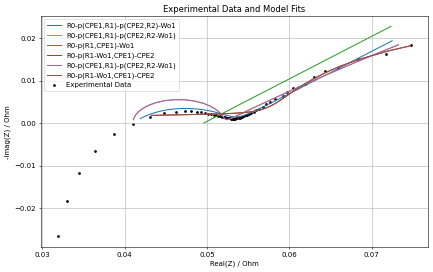

Parameters for circuit R0-p(CPE1,R1)-p(CPE2,R2)-Wo1: [4.11198294e-02 5.38168078e+00 6.20396748e-01 1.55193085e-03
 6.64431956e-01 6.44899750e-01 1.05006123e-02 3.08215076e-01
 2.17424550e+03]
MSE for circuit R0-p(CPE1,R1)-p(CPE2,R2)-Wo1: 3.0853106945892176e-05
Parameters for circuit R0-p(CPE1,R1)-p(CPE2,R2-Wo1): [4.09842424e-02 2.09919047e-02 9.99999990e-01 1.08600155e-02
 1.32252024e+02 4.84026637e-01 3.85444659e-01 7.72598593e-13
 3.38445955e+02]
MSE for circuit R0-p(CPE1,R1)-p(CPE2,R2-Wo1): 2.897932687604211e-05
Parameters for circuit R0-p(R1,CPE1)-Wo1: [4.96210305e-02 6.49214868e+06 1.16029498e+06 1.60426639e-01
 5.87124899e-01 5.69954669e+03]
MSE for circuit R0-p(R1,CPE1)-Wo1: 4.838603631733592e-05
Parameters for circuit R0-p(R1-Wo1,CPE1)-CPE2: [6.47450202e-36 2.11590006e-02 9.92124652e-02 1.18554269e+03
 5.21069138e+02 1.00000000e+00 1.72684192e+01 2.63632168e-02]
MSE for circuit R0-p(R1-Wo1,CPE1)-CPE2: 3.4954027990862725e-05
Parameters for circuit R0-p(CPE1,R1)-p(CPE2,R2-Wo1): [

In [ ]:
# Plotting Z and model data
plt.figure(figsize=(10, 6), dpi = 50)
for model_data, _, circuit, _ in all_model_data:
    plt.plot(np.real(model_data), -np.imag(model_data), '-', label=circuit)
plt.scatter(df_NX001_2108_103['Re(Z)/Ohm'], df_NX001_2108_103['-Im(Z)/Ohm'], color='black', s=8, label='Experimental Data')
plt.xlabel('Real(Z) / Ohm')
plt.ylabel('-Imag(Z) / Ohm')
plt.title('Experimental Data and Model Fits')
plt.legend()
plt.grid(True)
plt.show()

for model_data, fitted_params, circuit, mse in all_model_data:
    print(f'Parameters for circuit {circuit}: {fitted_params}')
    print(f'MSE for circuit {circuit}: {mse}')

In [ ]:
#circuit = 'R0-p(CPE1,R1-Wo1)-p(CPE2,R2)-R3-p(R4,C0)-R5-p(R6,CPE3)-p(R7-Wo2, C1)-R8'

#model_data, fitted_params, mse = fit_ecm_model(df_NX001_2108_103, circuit, 21)

# Plotting Z and model data
#plt.figure(figsize=(10, 6), dpi = 50)
#plt.plot(np.real(model_data), -np.imag(model_data), '-', label=circuit)
#plt.scatter(df_NX001_2108_103['Re(Z)/Ohm'], df_NX001_2108_103['-Im(Z)/Ohm'], color='black', s=8, label='Experimental Data')
#plt.xlabel('Real(Z) / Ohm')
#plt.ylabel('-Imag(Z) / Ohm')
#plt.title('Experimental Data and Model Fits')
#plt.legend()
#plt.grid(True)
#plt.show()

#for model_data, fitted_params, circuit, mse in all_model_data:
    #print(f'Parameters for circuit {circuit}: {fitted_params}')
    #print(f'MSE for circuit {circuit}: {mse}')

### Thoughts and next steps

impedance.py is very streamlined, but its very slow for complex circuit models. Unless there's a way to speed it up, it probably won't be the best option to use.

**To do:**
- Do more research on ECMs, and gather a selection to try
- Look into ways of speeding up impedance or look into writing own piece of code to do what it does
- Consider making a function that iterates through lots of ECMs and outputs the best one, might not be worth the time
- Compare MSEs for different ECMs
- Document findings
- Determine the physical link between equivalent circuit components and battery components

In [ ]:
#Code Graveyard

def fit_ecm_model(df, circuit='R0-p(R1,C1)-p(R2-Wo1,C2)', number_of_components=7):
    initial_guess = [1] * number_of_components
    freq = df['freq/Hz'].values
    Z = df['Re(Z)/Ohm'].values - 1j * df['-Im(Z)/Ohm'].values
    
    circuit_model = CustomCircuit(circuit, initial_guess=initial_guess)
    circuit_model.fit(freq, Z)
    Z_fit = circuit_model.predict(freq)

    fitted_params = circuit_model.parameters_
    mse = mean_squared_error(np.real(Z), np.real(Z_fit)) + mean_squared_error(np.imag(Z), np.imag(Z_fit))
    
    return Z_fit, fitted_params

circuit_models = [('R0-p(R1-Wo1,C1)', 5), ('R0-p(R1,C1)-p(R2-Wo1,C2)', 7), ('R0-p(R1,CPE1)-p(R2-Wo1,C2)', 8)]

all_model_data = []

# Measure data (assuming df_NX001_2108_103 is defined)
measured_data = (df_NX001_2108_103['Re(Z)/Ohm'] - 1j * df_NX001_2108_103['-Im(Z)/Ohm']).values

for circuit, number_of_components in circuit_models:
    model_data, _ = fit_ecm_model(df_NX001_2108_103, circuit, number_of_components)
    all_model_data.append((model_data, circuit))

# Create traces for experimental data
data_trace = go.Scatter(
    x=np.real(measured_data),
    y=-np.imag(measured_data),
    mode='markers',
    name='Experimental Data'
)

# Create Plotly figure with buttons
fig = go.Figure()

# Add experimental data trace
fig.add_trace(data_trace)

# Add traces for all model data
for model_data, circuit in all_model_data:
    model_trace = go.Scatter(
        x=np.real(model_data),
        y=-np.imag(model_data),
        mode='lines',
        name=f'Model - {circuit}',
        visible='legendonly'
    )
    fig.add_trace(model_trace)

# Create buttons
buttons = []
buttons.append(
    dict(label="All",
         method="update",
         args=[{"visible": [True] + [True] * len(all_model_data)},
               {"title": "All Data"}])
)
for i, (_, circuit) in enumerate(all_model_data):
    button = dict(label=f"{circuit}",
                  method="update",
                  args=[{"visible": [True] + [True] * i + [False] * (len(all_model_data) - i)},
                        {"title": f"Experimental Data + Model - {circuit}"}])
    buttons.append(button)

# Add buttons to the layout
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=0.57,
            y=1.2,
            buttons=buttons
        ),
    ],
    xaxis_title='Real(Z) / Ohm',
    yaxis_title='-Imag(Z) / Ohm',
    title=f'Nyquist plot for battery {battery_name_NX001_2108}, cycle 103, SOC = 33%',
    width=1000,  # Set width
    height=500  # Set height
)

fig.show()
